# Zapisywanie i wczytywanie modeli w PyTorch

Ten przykład pokazuje kompletny przepływ pracy: tworzymy prostą sieć neuronową w PyTorch, trenujemy ją na syntetycznych danych, zapisujemy na dysku, a następnie wczytujemy i wykorzystujemy do predykcji.

## 1. Importy i przygotowanie danych
Zaczynamy od importu bibliotek oraz przygotowania niewielkiego zbioru danych do regresji liniowej.

In [1]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

# Ustawienie ziaren losowych
torch.manual_seed(42)
np.random.seed(42)

# Dane wejściowe (x) i wyjściowe (y)
x = np.linspace(-1, 1, 200)
y = 3 * x + 2 + np.random.normal(0, 0.2, size=x.shape)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


## 2. Definicja modelu
Tworzymy prosty model sekwencyjny składający się z jednej warstwy liniowej.

In [2]:
class SimpleRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 1)
        )

    def forward(self, inputs):
        return self.net(inputs)

model = SimpleRegressor()
model


SimpleRegressor(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)

## 3. Trening modelu
Trenujemy model przez kilkaset epok, zapisując przebieg straty do wizualizacji.

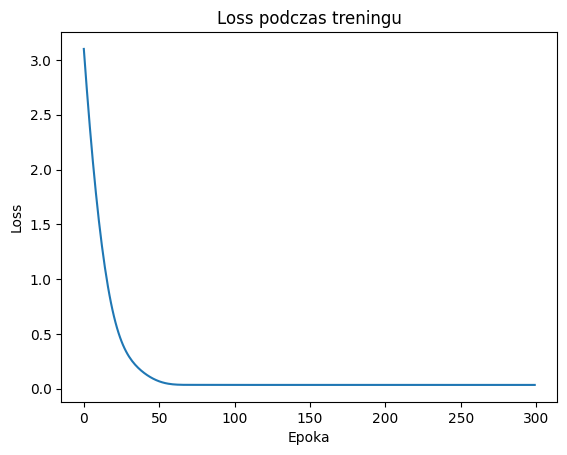

In [3]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
loss_history = []

for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    predictions = model(x_tensor)
    loss = criterion(predictions, y_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

plt.plot(loss_history)
plt.title('Loss podczas treningu')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.show()


## 4. Zapis modelu
W PyTorch najczęściej zapisujemy tylko `state_dict`, czyli słownik parametrów. Dla pełni obrazu zapisujemy także cały model.

In [8]:
state_dict_path = 'simple_regressor.pt'

torch.save(model.state_dict(), state_dict_path)
torch.save(model, full_model_path)

print('Zapisano state_dict do:', state_dict_path)
print('Zapisano pełny model do:', full_model_path)


Zapisano state_dict do: simple_regressor.pt
Zapisano pełny model do: simple_regressor_full.pth


## 5. Wczytanie modelu
Pokazujemy dwa warianty: wczytanie `state_dict` do świeżej instancji klasy oraz załadowanie pełnego modelu.

In [9]:
# Wczytanie state_dict
loaded_model = SimpleRegressor()
loaded_model.load_state_dict(torch.load(state_dict_path))
loaded_model.eval()

# # Wczytanie pełnego modelu
# loaded_full_model = torch.load(full_model_path)
# loaded_full_model.eval()


SimpleRegressor(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)

## 6. Predykcje z wczytanych modeli
Używamy wczytanych modeli do predykcji, aby upewnić się, że zachowują się tak samo jak oryginał.

In [11]:
x_test = torch.tensor([[-0.5], [0.0], [0.5]], dtype=torch.float32)

with torch.no_grad():
    preds_original = model(x_test)
    preds_loaded = loaded_model(x_test)
    # preds_loaded_full = loaded_full_model(x_test)

print('Predykcje (oryginalny model):', preds_original.flatten().numpy())
print('Predykcje (state_dict):', preds_loaded.flatten().numpy())
# print('Predykcje (pełny model):', preds_loaded_full.flatten().numpy())


Predykcje (oryginalny model): [0.48044562 1.991846   3.5032463 ]
Predykcje (state_dict): [0.48044562 1.991846   3.5032463 ]


## 7. Porównanie wag
Sprawdzamy, czy wagi wczytanych modeli są identyczne z wagami modelu oryginalnego.

In [12]:
def compare_parameters(model_a, model_b):
    return all(torch.allclose(p_a, p_b) for p_a, p_b in zip(model_a.parameters(), model_b.parameters()))

print('Czy wagi po wczytaniu state_dict są identyczne?', compare_parameters(model, loaded_model))
# print('Czy wagi po wczytaniu pełnego modelu są identyczne?', compare_parameters(model, loaded_full_model))


Czy wagi po wczytaniu state_dict są identyczne? True


## 8. Podsumowanie
1. Zbudowaliśmy i wytrenowaliśmy prosty model w PyTorch.
2. Zapisaliśmy model jako `state_dict` oraz jako pełny obiekt.
3. Wczytaliśmy oba warianty i wykorzystaliśmy je do predykcji.
4. Potwierdziliśmy, że parametry po zapisie i odczycie pozostają spójne.

W praktyce najczęściej przechowuje się `state_dict`, ponieważ daje większą kontrolę nad konstrukcją modelu podczas ponownego wczytywania.